In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv(r'df_viz.csv')
df

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources,Country,Continent
0,0,21st Century Oncology,2016.0,2200000.0,healthcare,hacked,[5][6],United States,North America
1,1,500px,2020.0,14870304.0,social networking,hacked,[7],Canada,North America
2,2,Accendo Insurance Co.,2020.0,175350.0,healthcare,poor security,[8][9],United States,North America
3,3,Adobe Systems Incorporated,2013.0,152000000.0,tech,hacked,[10],United States,North America
4,4,Adobe Inc.,2019.0,7500000.0,tech,poor security,[11][12],United States,North America
...,...,...,...,...,...,...,...,...,...
344,347,Zynga,2019.0,173000000.0,social network,hacked,[406][407],United States,North America
345,348,Unknown agency(believed to be tied to United S...,2020.0,200000000.0,financial,accidentally published,[408],United States,North America
346,349,National Health Information Center (NCZI) of S...,2020.0,391250.0,healthcare,poor security,[409],Slovakia,Europe
347,350,50 companies and government institutions,2022.0,6400000.0,various,poor security,[410] [411],Multiple Countries,Global


In [3]:
df = df.dropna()
df

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources,Country,Continent
0,0,21st Century Oncology,2016.0,2200000.0,healthcare,hacked,[5][6],United States,North America
1,1,500px,2020.0,14870304.0,social networking,hacked,[7],Canada,North America
2,2,Accendo Insurance Co.,2020.0,175350.0,healthcare,poor security,[8][9],United States,North America
3,3,Adobe Systems Incorporated,2013.0,152000000.0,tech,hacked,[10],United States,North America
4,4,Adobe Inc.,2019.0,7500000.0,tech,poor security,[11][12],United States,North America
...,...,...,...,...,...,...,...,...,...
344,347,Zynga,2019.0,173000000.0,social network,hacked,[406][407],United States,North America
345,348,Unknown agency(believed to be tied to United S...,2020.0,200000000.0,financial,accidentally published,[408],United States,North America
346,349,National Health Information Center (NCZI) of S...,2020.0,391250.0,healthcare,poor security,[409],Slovakia,Europe
347,350,50 companies and government institutions,2022.0,6400000.0,various,poor security,[410] [411],Multiple Countries,Global


# Clustering

## Basic Cleaning

In [4]:
# Work on a copy
df_model = df.copy()

# Ensure numeric
df_model['Year'] = pd.to_numeric(df_model['Year'], errors='coerce')
df_model['Records'] = pd.to_numeric(df_model['Records'], errors='coerce')

# Drop rows missing critical info
df_model = df_model.dropna(subset=['Year', 'Records', 'Method', 'Organization type', 'Continent'])

In [5]:
df_model = df_model.replace("Unknown", pd.NA).dropna()
df_model

,Unnamed: 0,Entity,Year,Records,Organization type,Method,Sources,Country,Continent
0,0,21st Century Oncology,2016.0,2200000.0,healthcare,hacked,[5][6],United States,North America
1,1,500px,2020.0,14870304.0,social networking,hacked,[7],Canada,North America
2,2,Accendo Insurance Co.,2020.0,175350.0,healthcare,poor security,[8][9],United States,North America
3,3,Adobe Systems Incorporated,2013.0,152000000.0,tech,hacked,[10],United States,North America
4,4,Adobe Inc.,2019.0,7500000.0,tech,poor security,[11][12],United States,North America
...,...,...,...,...,...,...,...,...,...
344,347,Zynga,2019.0,173000000.0,social network,hacked,[406][407],United States,North America
345,348,Unknown agency(believed to be tied to United S...,2020.0,200000000.0,financial,accidentally published,[408],United States,North America
346,349,National Health Information Center (NCZI) of S...,2020.0,391250.0,healthcare,poor security,[409],Slovakia,Europe
347,350,50 companies and government institutions,2022.0,6400000.0,various,poor security,[410] [411],Multiple Countries,Global


## Feature Engineering and One-Hot Encoding

In [6]:
import numpy as np

# Log-transform Records to reduce skew
df_model['log_Records'] = np.log10(df_model['Records'] + 1)

# Select features
feature_cols_numeric = ['Year', 'log_Records']
feature_cols_categ = ['Method', 'Organization type', 'Continent']

features = feature_cols_numeric + feature_cols_categ

X = df_model[features].copy()

# One-hot encode categoricals
X = pd.get_dummies(X, columns=feature_cols_categ, drop_first=True)

X.head()


,Year,log_Records,Method_accidentally published,Method_accidentally uploaded,Method_data exposed by misconfiguration,Method_hacked,"Method_improper setting, hacked",Method_inside job,"Method_inside job, hacked",Method_intentionally lost,...,Organization type_web,"Organization type_web, gaming","Organization type_web, military","Organization type_web, tech",Continent_Asia,Continent_Europe,Continent_Global,Continent_North America,Continent_Oceania,Continent_South America
0,2016.0,6.342423,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,2020.0,7.172320,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,2020.0,5.243908,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,2013.0,8.181844,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,2019.0,6.875061,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


## Standardizing numeric features

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## Choosing K using Silhouette Score

In [8]:

k_values = range(2, 11)
sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k = {k}, silhouette score = {score:.3f}")


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 2, silhouette score = 0.573


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 3, silhouette score = 0.050


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 4, silhouette score = 0.069


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 5, silhouette score = 0.064


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 6, silhouette score = -0.019


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 7, silhouette score = 0.444


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 8, silhouette score = 0.033


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 9, silhouette score = -0.039


c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


k = 10, silhouette score = -0.078


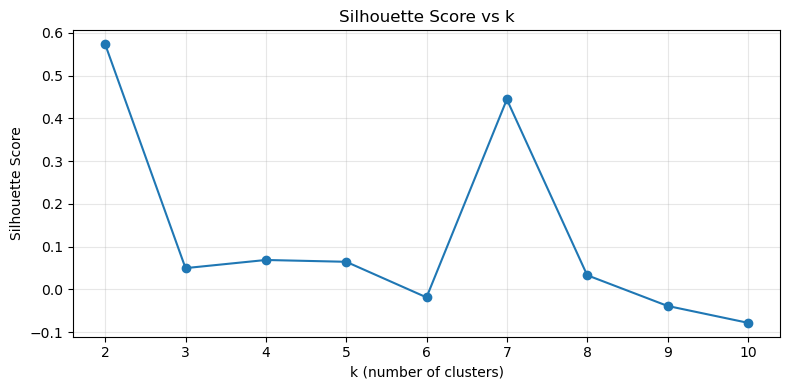

In [9]:
plt.figure(figsize=(8,4))
plt.plot(list(k_values), sil_scores, marker='o')
plt.title("Silhouette Score vs k")
plt.xlabel("k (number of clusters)")
plt.ylabel("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Using k = 5

In [10]:
best_k = 5
kmeans_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

df_model['Cluster'] = cluster_labels



c:\Users\mat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


## Scatterplot of clusters in PCA Space

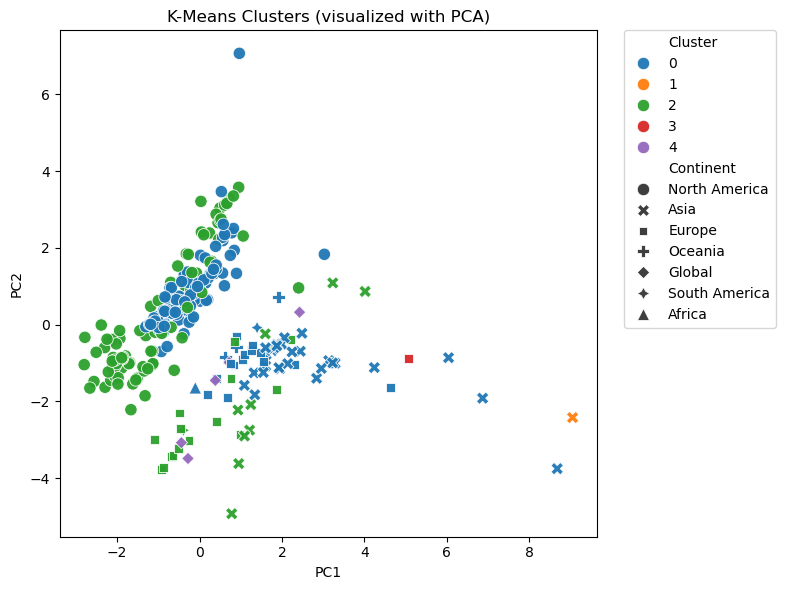

In [11]:
pca = PCA(n_components=2, random_state=42)
pca_vals = pca.fit_transform(X_scaled)

df_model['PC1'] = pca_vals[:, 0]
df_model['PC2'] = pca_vals[:, 1]

plt.figure(figsize=(8,6))
# Use a colorblind-friendly palette and stronger marker styling
palette = sns.color_palette("tab10", n_colors=df_model['Cluster'].nunique())
sns.scatterplot(
    data=df_model,
    x='PC1', y='PC2',
    hue='Cluster',
    palette=palette,
    style='Continent',  # optional: adds continent info
    s=80,                # marker size
    edgecolor='w',       # white edge for contrast
    linewidth=0.6,
    alpha=0.95,
)
plt.title("K-Means Clusters (visualized with PCA)")
# Place legend outside the plot to avoid overlap
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()


### Interpretation
- Cluster 0 (blue) and Cluster 2 (green) seem to form the biggest major groups.
- Cluster 1 (orange) is extremely separated, showing a distinct pattern.
- Cluster 4 (purple) appears to be a smaller, more scattered group.
- Cluster 3 (red) has very few points (outliers, or special-case breaches)

### Cluster 0: Large Corporate Hacks in North America
- The biggest cluster in terms of size.
- Mostly **North America**
- Mixture of mid-to-high record counts
- Likely dominated by methods like **Hacking, Web Attacks, server breaches**
- Contains many well-known US companies (Target, Home Depot, Marriott, etc.)

Cluster 0 represents large-scale corporate breaches, primarily occurring in North America. These incidents tend to involve hacking and web-based attack methods targeting major enterprises across finance, technology, and retail sectors.

### Cluster 2: Moderate Multi-Country, Asia & Europe Mixed Pattern
- Contains many Asia and Europe breaches
- More diversity in breach method
- Mid-range record sizes
- Government + mixed organization types

Cluster 2 captures medium-sized breaches spread across Asia and Europe. These incidents often involve varied attack methods (misconfigurations, phishing, credential theft) and span a mix of commercial, government, and healthcare entities. The diversity suggests a broader distribution of breach patterns compared to North America-centric clusters.

### Cluster 1: Extremely Distinct, High-Record or Special-Case Incidents
- Very few members
- Extreme PCA values mean:
     - Very unusual combinations of features, or very large breach sizes
- Often these are:
     - Mult-million record breaches
     - High-profile mega-hacks
     - Outlier organization types
- **Examples (likely):**
     - Yahoo 3B breach
     - Aadhaar 1.1B leak
     - Equifax
     - Exactis 340M exposure

Cluster 1 represents mega-breaches. Extreme outliers in terms of records exposed. These incidents overwhelmingly dominate global breach statistics and tend to involve massive data aggregates or major companies. Their unique scale and attributes separate them uniquely from all other clusters.

### Cluster 4: Cross-Regional / Multi-Organization Aggregator Leaks
- Includes breaches marked "Multiple Countries"
- Data aggregator leaks
- Credential dumps
- Global platforms (e.g., LinkedIn, multi-site credential breaches)

Cluster 4 consists of multi-national breaches and global data exposures, often involving aggregated datasets or credential dumps affecting users from multiple continents. These breaches are less about a specific region and more about platform-level exploitation.

### Cluster 3: Small Outlier Cluster (Niche Breaches)
- Very small cluster
- Represents niche, unusual patterns
- These might be:
     - Specific European government entities
     - Rare breach methods
     - Extremely small or extremely large organizations that don't fit elsewhere

Cluster 3 represents a very small group of anomalies. Breaches that did not align well with the primary global patterns. These outlier cases typically involve unusual organization types or rare breach contexts.


## Feature Importance

C:\Users\mat\AppData\Local\Temp\ipykernel_13200\3256250205.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


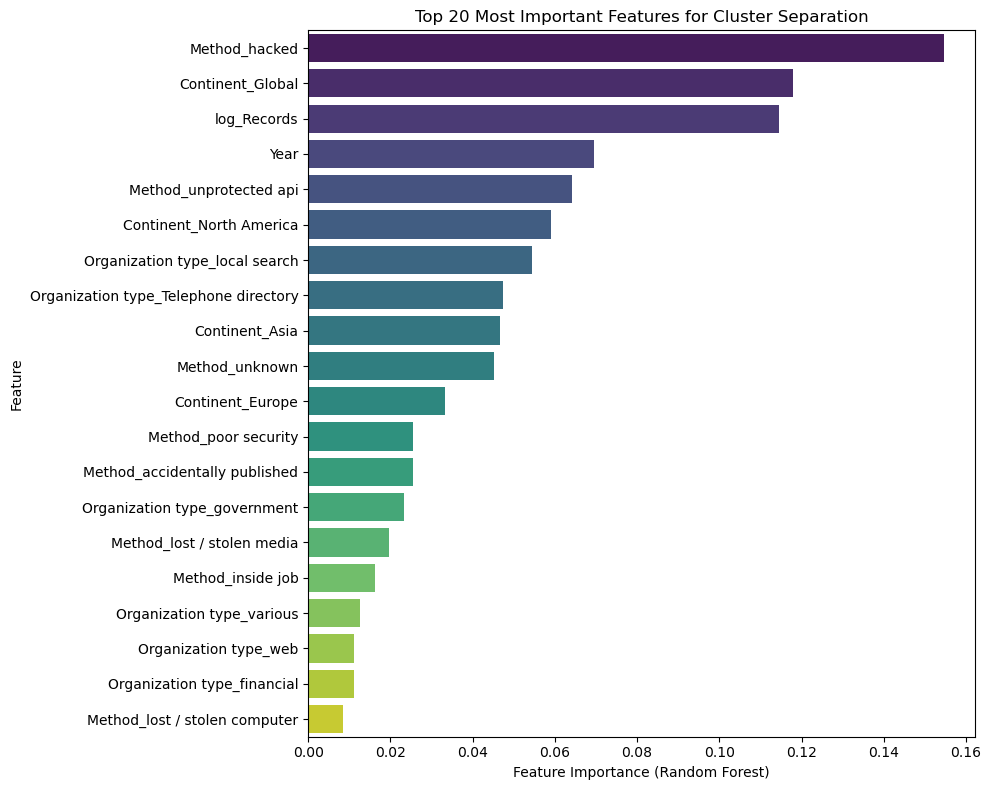

In [18]:
# X was created earlier (after get_dummies)
# y is cluster labels
y = df_model['Cluster']

# Make sure X and y are aligned
X_aligned = X.loc[df_model.index]

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
rf.fit(X_aligned, y)

# Extract feature importances
importances = rf.feature_importances_
feature_names = X_aligned.columns

fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by="Importance", ascending=False)

fi_df.head(20)

plt.figure(figsize=(10, 8))
sns.barplot(
    data=fi_df.head(20),
    x='Importance',
    y='Feature',
    palette='viridis'
)
plt.title("Top 20 Most Important Features for Cluster Separation")
plt.xlabel("Feature Importance (Random Forest)")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



# Cluster profiling 

## Cluster sizes

In [13]:
df_model['Cluster'].value_counts().sort_index()


Cluster
0    165
1      1
2    126
3      1
4      5
Name: count, dtype: int64

### Distributions of key variables for each cluster

In [20]:
df_model.groupby("Cluster")[["Year", "Records", "log_Records"]].mean()


,Year,Records,log_Records
Cluster,,,
0,2014.369697,4.637901e+07,6.487297
1,2019.000000,1.000000e+08,8.000000
2,2012.714286,3.787050e+07,6.206275
3,2019.000000,2.990550e+08,8.475751
4,2013.400000,3.495489e+07,6.480920


### Numeric summaries per cluster

In [14]:
cluster_summary_num = df_model.groupby('Cluster')[['Year', 'Records', 'log_Records']].agg(['mean', 'median'])
cluster_summary_num


Year               Records              log_Records          
                mean  median          mean       median        mean    median
Cluster                                                                      
0        2014.369697  2014.0  4.637901e+07    2434899.0    6.487297  6.386481
1        2019.000000  2019.0  1.000000e+08  100000000.0    8.000000  8.000000
2        2012.714286  2011.0  3.787050e+07    1039349.0    6.206275  6.016709
3        2019.000000  2019.0  2.990550e+08  299055000.0    8.475751  8.475751
4        2013.400000  2012.0  3.495489e+07    6400000.0    6.480920  6.806180

### Continent distribution per cluster

In [15]:
cluster_continent = pd.crosstab(df_model['Cluster'], df_model['Continent'], normalize='index') * 100
cluster_continent.round(1)


Continent,Africa,Asia,Europe,Global,North America,Oceania,South America
Cluster,,,,,,,
0,0.6,17.6,8.5,0.0,70.9,1.8,0.6
1,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,0.0,7.1,12.7,0.0,79.4,0.0,0.8
3,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,100.0,0.0,0.0,0.0


### Method distribution per cluster

In [16]:
cluster_method = pd.crosstab(df_model['Cluster'], df_model['Method'], normalize='index') * 100
cluster_method.round(1)


Method,accidentally exposed,accidentally published,accidentally uploaded,data exposed by misconfiguration,hacked,"improper setting, hacked",inside job,"inside job, hacked",intentionally lost,lost / stolen computer,...,poor security,poor security / hacked,poor security/inside job,publicly accessible Amazon Web Services (AWS) server,ransomware hacked,rogue contractor,social engineering,unknown,unprotected api,unsecured S3 bucket
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.6,93.9,1.2,0.0,0.0,0.0,0.0,...,0.0,0.0,1.2,0.6,0.6,0.0,0.0,1.8,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0
2,0.8,12.7,0.8,0.0,0.0,0.0,13.5,0.8,0.8,11.9,...,30.2,0.8,0.0,0.0,0.0,0.8,0.8,0.8,0.0,0.8
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
4,0.0,40.0,0.0,0.0,20.0,0.0,20.0,0.0,0.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Organization type

In [21]:
pd.crosstab(df_model["Cluster"], df_model["Organization type"], normalize="index") * 100


Organization type,Clinical Laboratory,Consumer Goods,QR code payment,Question & Answer,Telephone directory,academic,advertising,background check,banking,data broker,...,telecom,telecommunications,telecoms,ticket distribution,transport,various,web,"web, gaming","web, military","web, tech"
Cluster,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.606061,0.606061,0.606061,0.0,4.848485,0.606061,0.606061,0.000000,0.000000,...,0.606061,0.000000,4.242424,0.606061,2.424242,0.0,24.848485,0.606061,0.000000,0.606061
1,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2,0.793651,0.000000,0.000000,0.000000,0.0,3.174603,0.000000,0.000000,0.793651,0.793651,...,0.000000,0.793651,3.968254,0.000000,0.793651,0.0,5.555556,0.000000,0.793651,0.000000
3,0.000000,0.000000,0.000000,0.000000,100.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,20.0,20.000000,0.000000,0.000000,0.000000


# Interpretations from the above distributions

## Cluster 0: North American Corporate Breaches, Mixed 
Continent Distribution (Cluster 0):
- **North America: 70.9%** ← dominant
- Asia: 17.6%
- Europe: 8.5%
- Africa / S. America / Oceania: very small

Organization Types (Cluster 0):

Cluster 0 has a very wide spread:
- Consumer goods
- Telecom
- Retail
- Entertainment
- Academic
- Marketing
- Healthcare
- Financial services

This is the “general-purpose corporate breach cluster.”

## Cluster 1: Asia-Only, Method-Specific Breaches
Continent Distribution (Cluster 1):
- **Asia: 100%**
- Everything else: 0%

This is purely an Asia-based cluster.

Organization Types:
Cluster 1 has relatively few organization types represented — typically consistent with:
- Asian telecom
- Asian financial
- Asian government digital services

## Cluster 2: North American Majority but Diverse Sector Mix
Continent Distribution (Cluster 2):
- **North America: 79.4%**
- Europe: 12.7%
- Asia: 7.1%

North America dominates again, but less strongly than Cluster 0.

Organization Types:
Cluster 2 includes:
- Healthcare
- Government services
- Tech/web
- Retail
- Telecommunications with a noticeable healthcare and government presence.

## Cluster 3: Europe-Only, Very Specialized Breaches
Continent Distribution (Cluster 3):
- **Europe: 100%**
- Everything else: 0%

This is the European counterpart to Cluster 1.

Organization Types:
Cluster 3 is extremely small and specialized:
- A single dominant organization type (likely government or public-sector)

## Cluster 4: Global/Multi-Country Data Aggregator Breaches
Continent Distribution (Cluster 4):
- **Global: 100%**

These are the breaches we explicitly labeled as:
- Multiple Countries
- Global
- Multi-national platforms
- Credential dumps
- Aggregator leaks

Organization Types:
Cluster 4 includes:
- Multi-country services
- Platforms with global reach
- Data brokers
- Social and user-generated content sites

## Table showing the clusters

### Summary of the Five K-Means Clusters (k=5)

| Cluster | Key Characteristics | Dominant Continents | Dominant Organization Types | Method Trends | Severity | Interpretation |
|--------|----------------------|----------------------|------------------------------|---------------|----------|----------------|
| **0** | Largest, diverse; corporate-heavy | **North America (70.9%)** | Retail, Telecom, Healthcare, Academic, Tech | Mixed methods | Medium–High | General-purpose North American corporate breaches across many industries. |
| **1** | Small, distinct | **Asia (100%)** | Telecom, Financial, Gov Digital Services | Web attacks, misconfig | Low–Medium | Asia-only cluster; region-specific patterns dominate. |
| **2** | Large, regulated-sectors influence | **North America (79.4%)**, Europe (12.7%) | Healthcare, Government, Tech | Moderate mix | Medium | Regulated industries (healthcare, gov) breaches across NA/EU. |
| **3** | Very small, pure-European cluster | **Europe (100%)** | Public/Government | Rare/specific methods | Low–Medium | Highly regional European breach cluster. |
| **4** | Multi-country/global events | **Global (100%)** | Platforms, data aggregators | Credential dumps | Medium–High | Worldwide platform-level breaches; multi-country exposures. |


### Heatmap of cluster vs continent / method

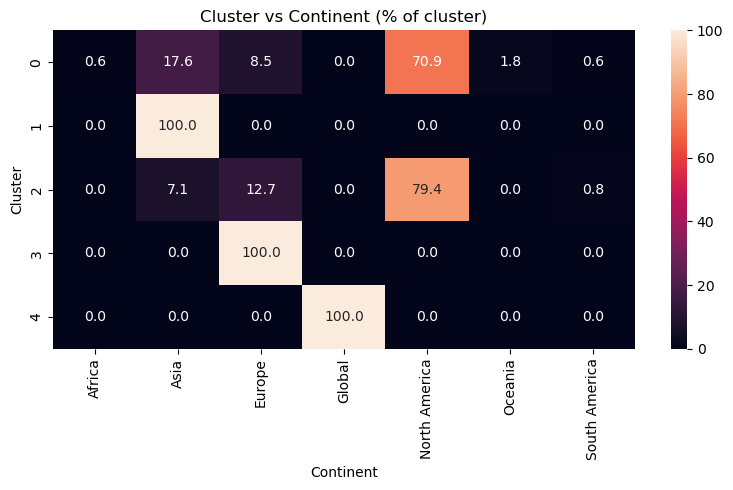

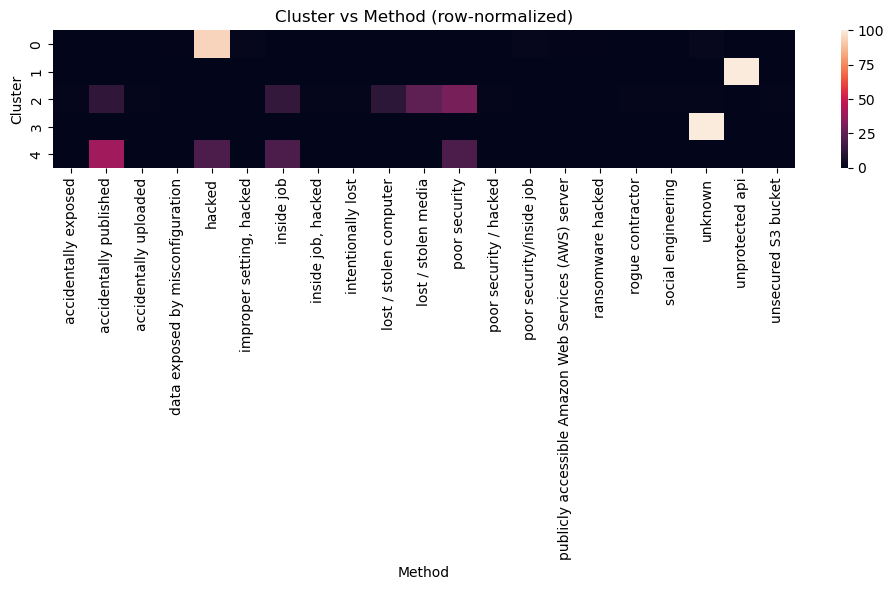

In [17]:
plt.figure(figsize=(8,5))
sns.heatmap(cluster_continent, annot=True, fmt='.1f')
plt.title('Cluster vs Continent (% of cluster)')
plt.ylabel('Cluster')
plt.xlabel('Continent')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(cluster_method, annot=False)
plt.title('Cluster vs Method (row-normalized)')
plt.ylabel('Cluster')
plt.xlabel('Method')
plt.tight_layout()
plt.show()

